## Classificador binário para características morfométricas de núcleo 

In [352]:
import numpy as np
import pandas as pd 
from math import sqrt
import os
import sys
import csv
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
from skimage import morphology, measure
from skimage.draw import polygon, polygon_perimeter
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis

import pyefd
from pyefd import elliptic_fourier_descriptors, normalize_efd

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import feature_selection as fs
from sklearn import preprocessing

from datetime import datetime

# pay attention to capitalization below!
from spFSR import SpFSR
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE

from itertools import cycle
from random import randint
from random import sample

import xgboost as xgb 


In [353]:
Bethesda_classes = {'Normal':0, 'ASC-US':1, 'ASC-H':2, 'LSIL':3,'HSIL':4, 'Invasive Carcinoma':5} 
Bethesda_idx_classes = {0: 'Normal', 1:'ASC-US', 2:'ASC-H', 3:'LSIL',4: 'HSIL', 5:'Invasive Carcinoma'} 

### Funções para normalizar (todos os dados)

In [354]:
## Normaliza dados
def normalize(min, max, value):
    return (value-min)/(max - min)

def normalize_prop(prop, df):
    min = np.min(df[prop].values)
    max = np.max(df[prop].values)
    return (normalize(min, max, df[prop].values))

# ALTERADO Filtra/normaliza dados
def normalize_dataset(df, n_efd_coeffs):
  dataset = df.copy()
   
  dataset.areaN = normalize_prop('areaN', df)
  dataset.eccenN = normalize_prop('eccenN', df) 
  dataset.extentN = normalize_prop('extentN', df)
  dataset.periN = normalize_prop('periN', df)
  dataset.maxAxN = normalize_prop('maxAxN', df)  
  dataset.minAxN = normalize_prop('minAxN', df)  
  dataset.compacN = normalize_prop('compacN', df)
  dataset.circuN = normalize_prop('circuN', df)
  dataset.convexN = normalize_prop('convexN', df)
  dataset.hAreaN = normalize_prop('hAreaN', df)
  dataset.solidN = normalize_prop('solidN', df) 
  dataset.equidiaN = normalize_prop('equidiaN', df) 
  dataset.elonN = normalize_prop('elonN', df)
  dataset.eN = normalize_prop('eN', df)  
  dataset.kN = normalize_prop('kN', df)  
  dataset.mrdN = normalize_prop('mrdN', df)  
  dataset.ardN = normalize_prop('ardN', df)  
  dataset.fdN = normalize_prop('fdN', df)       
  efds = ['efdN'+str(i) for i in range(1,(n_efd_coeffs*4 + 1 - 3))]
  for efd in efds: 
      dataset[efd] = normalize_prop(efd, df) 
  
  ''' 
  dataset.areaC = normalize_prop('areaC', df)
  dataset.eccenC = normalize_prop('eccenC', df) 
  dataset.extentC = normalize_prop('extentC', df)
  dataset.periC = normalize_prop('periC', df)
  dataset.maxAxC = normalize_prop('maxAxC', df)  
  dataset.minAxC = normalize_prop('minAxC', df)
  dataset.compacC = normalize_prop('compacC', df)
  dataset.circuC = normalize_prop('circuC', df)
  dataset.convexC = normalize_prop('convexC', df)
  dataset.hAreaC = normalize_prop('hAreaC', df)
  dataset.solidC = normalize_prop('solidC', df) 
  dataset.equidiaC = normalize_prop('equidiaC', df) 
  dataset.elonC = normalize_prop('elonC', df)
  dataset.eC = normalize_prop('eC', df)  
  dataset.kC = normalize_prop('kC', df)  
  dataset.mrdC = normalize_prop('mrdC', df)  
  dataset.ardC = normalize_prop('ardC', df)  
  dataset.fdC = normalize_prop('fdC', df)       
  efds = ['efdC'+str(i) for i in range(1,(n_efd_coeffs*4 + 1 - 3))]
  for efd in efds: 
      dataset[efd] = normalize_prop(efd, df)   

  #dataset.nucleus_position = normalize_prop('nucleus_position', df)
  '''
  return dataset

 ###  Funções - organiza dados (x, y, ids) e filtra base para diferentes classificadores:

In [355]:
 #Monta base e retorna 3 dataframes: data (x), target(2,3 e 6 classes), image/cell_id
def get_database_data_targe_ids(data_normal, data_ascus, 
                       data_lsil, data_asch, data_hsil,data_car,
                       features_to_fit):
 
    data =  pd.DataFrame(data=np.vstack([
                          data_normal.values,
                          data_ascus.values,
                          data_asch.values,
                          data_lsil.values, 
                          data_hsil.values,
                          data_car.values]), 
                         columns = data_car.columns)
    
    ## ID's imagens e celulas
    image_cells_ids= data[['image_id', 'cell_id']].copy() 
    
    ##Ajusta y(target) para classificação binária, ternária além de bethesda
    y = np.array(data['bethesda'].values)
    y_bin = np.array(y)
    y_ter = np.array(y)
        
    for i in range(data.shape[0]):
         y_bin[i] = 0 if y_bin[i]==0 else 1
    
    for i in range(data.shape[0]):
          if y_ter[i] == 3:  ##Lsil
             y_ter[i] = 1
          elif (y_ter[i] == 4 or y_ter[i] == 5):  ##HSIl e Car
                y_ter[i] = 2
                
    target = pd.DataFrame(data = np.stack([y_bin,
                                           y_ter,
                                           y], axis=-1),
                          columns = ['binary', 'ternary', 'bethesda'])
    
    data = data[features_to_fit]      
    return data, target, image_cells_ids

In [356]:
## Prepara dados para tuning de parâmetros
## Valores para type: 1 (normal/anormal), 2(baixo/alto grau), 3(ASCUS/LSIL), 4(ASCH/HSIL/CAR)

def filter_dataXY(X, y, cls_type):
    # X e y devem ser do tipo dataframe 
    
    if cls_type == 1: # (normal/anormal)
        return (X, y['binary'])
    elif cls_type == 2: # (baixo/alto grau)
          lines = filter_lines(y['ternary'], [1,2])
          return (X.loc[lines], y['ternary'].loc[lines])  
    elif cls_type == 3: # (ASCUS/LSIL)
          lines = filter_lines(y['bethesda'], [1,3])
          return (X.loc[lines], y['bethesda'].loc[lines])  
    else: #(ASCH/HSIL/Car)    
          lines = filter_lines(y['bethesda'], [2,4,5])
          return (X.loc[lines], y['bethesda'].loc[lines])                           

## Filtra linhas
def filter_lines(y, cls):
   lines = []
   for idx, value in zip(y.index, y.values):
        if (value in cls):
            lines.append(idx)
   return lines

## Filtra dados para teste do classificador 2 com base nas predições do classificador 1:
def filter_Xy_from_cls1_to_cls2(data, target, predics_bin, idx_test):
    lines = []
    for i in idx_test:
        if predics_bin[i] == 1: #Anormal  
             lines.append(i)
            
    X = data.loc[lines]
    y = target['ternary'].loc[lines]
    return (lines, X, y)

## Filtra dados para teste do classificador 3 com base nas predições do classificador 2:
def filter_Xy_from_cls1_to_cls3(data, target, predics_ter, idx_test):
    lines = []
    for i in idx_test:
        if predics_ter[i] == 1:  #lesão de baixo grau
             lines.append(i)
            
    X = data.loc[lines]
    y = target['bethesda'].loc[lines]
    return (lines, X, y)

## Filtra dados para teste do classificador 4 com base nas predições do classificador 2:
def filter_Xy_from_cls2_to_cls4(data, target, predics_ter, idx_test):
    lines = []
    for i in idx_test:
        if predics_ter[i] == 2:  #lesão de baixo grau
             lines.append(i)
            
    X = data.loc[lines]
    y = target['bethesda'].loc[lines]
    return (lines, X, y)

## Seleciona indices com pred = cls de idx_test          
def index_pred_from_class(idx_test, pred_y, cls=0):
    idx = []
    for i, pred in zip(idx_test, pred_y):
        if (pred == cls):
            idx.append(i)
    return idx
 
## Contabiliza tempo:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        

### Funções para seleção de características:

In [357]:
def list_all_features(n_efd_coeffs):
   # n_efd_coeffs: número de coefficientes a considerar (série Eliptica de fourier - EFD) para N e C
     
   feature_labels=['areaN', 'eccenN', 'extentN', 'periN', 'maxAxN', 'minAxN',
                   'compacN', 'circuN', 'convexN', 'hAreaN', 'solidN', 'equidiaN', 
                   'elonN', 'sdnrlN', 'raN', 'riN', 'eN', 'kN', 'mrdN', 'ardN', 'fdN'] 
   
   efdNs = ['efdN'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdNs:
       feature_labels.append(name_f) 
   
   aux=['areaC', 'eccenC', 'extentC', 'periC', 'maxAxC', 'minAxC',
         'compacC', 'circuC', 'convexC', 'hAreaC', 'solidC', 'equidiaC', 
          'elonC', 'sdnrlC', 'raC', 'riC', 'eC', 'kC', 'mrdC', 'ardC', 'fdC'] 
   for name_f in aux:
       feature_labels.append(name_f)

   efdCs = ['efdC'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdCs:
       feature_labels.append(name_f)
    
   aux = ['ratio_NC', 'ratio_NC_per', 'ratio_NC_hArea', 'nucleus_position']

   for name_f in aux:
       feature_labels.append(name_f)
   return feature_labels   

def list_all_EFD_features(n_efd_coeffs):
   # n_efd_coeffs: número de coefficientes a considerar (série Eliptica de fourier - EFD) para N e C

   feature_labels = ['efdN'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]      
   efdCs = ['efdC'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdCs:
       feature_labels.append(name_f)
   return feature_labels   


def list_all_nucleus_features(n_efd_coeffs):
   # n_efd_coeffs: número de coefficientes a considerar (série Eliptica de fourier - EFD) para N e C
     
   feature_labels=['areaN', 'eccenN', 'extentN', 'periN', 'maxAxN', 'minAxN',
                   'compacN', 'circuN', 'convexN', 'hAreaN', 'solidN', 'equidiaN', 
                   'elonN', 'sdnrlN', 'raN', 'riN', 'eN', 'kN', 'mrdN', 'ardN', 'fdN'] 
   
   efdNs = ['efdN'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdNs:
       feature_labels.append(name_f) 
    
   #TODO: incluir features abaixo? 
   #aux = ['ratio_NC', 'ratio_NC_per', 'ratio_NC_hArea', 'nucleus_position']
   #for name_f in aux:
   #    feature_labels.append(name_f)

   return feature_labels   

def list_all_cyto_features(n_efd_coeffs):
   # n_efd_coeffs: número de coefficientes a considerar (série Eliptica de fourier - EFD) para N e C
     
   feature_labels =['areaC', 'eccenC', 'extentC', 'periC', 'maxAxC', 'minAxC',
         'compacC', 'circuC', 'convexC', 'hAreaC', 'solidC', 'equidiaC', 
          'elonC', 'sdnrlC', 'raC', 'riC', 'eC', 'kC', 'mrdC', 'ardC', 'fdC'] 

   efdCs = ['efdC'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdCs:
       feature_labels.append(name_f)
    
   #aux = ['ratio_NC', 'ratio_NC_per', 'ratio_NC_hArea', 'nucleus_position']
   #for name_f in aux:
   #    feature_labels.append(name_f)
    
   return feature_labels   

In [358]:
len(list_all_features(20)), len(list_all_nucleus_features(20)), len(list_all_cyto_features(20)), len(list_all_EFD_features(20))

(200, 98, 98, 154)

In [359]:
### FEATURES SELECTION: "Simultaneous Perturbation Stochastic Approximation (SPSA) for feature selection and ranking" 
# Fonte: An implementation of feature selection and ranking via SPSA based on the article "K-best feature selection and ranking via stochastic approximation"(https://www.sciencedirect.com/science/article/abs/pii/S0957417422018826) 
# Código: https://github.com/akmand/spFSR.git
def features_selection_spfsr(X_train, y_train, N_FEATURES = None):        
    # pred_type needs to be 'c' for classification and 'r' for regression datasets
    sp_engine = SpFSR(x=X_train.values, y=y_train.values, pred_type='c', wrapper=None, scoring='accuracy')
    
    np.random.seed(999)

    if N_FEATURES is not None:
        sp_output = sp_engine.run(num_features=N_FEATURES).results    
    else:
        sp_output = sp_engine.run(num_features=0).results    

    fs_indices_spfsr = sp_output.get('selected_features')
    best_features_spfsr = np.array(features)[fs_indices_spfsr]
    feature_importances_spfsr = sp_output.get('selected_ft_importance')
    
    return(best_features_spfsr, feature_importances_spfsr)

                             
### FEATURES SELECTION: método Mutual Information
def features_selection_mi(X_train, y_train, list_features, N_FEATURES = 20):    
    # All features list:
    features = list_features
    
    aux = [0.0 for i in features]
    features_importances = dict(zip(features, aux))
  
    ## Feature Selection using Mutual Info  
    fs_fit_mutual_info = fs.SelectKBest(fs.mutual_info_classif, k=N_FEATURES)
    fs_fit_mutual_info.fit_transform(X_train, y_train)

    # ordena extrai do maior score para o menor entre as n_features mais importantes
    fs_indices_mutual_info = np.argsort(fs_fit_mutual_info.scores_)[::-1][0:N_FEATURES] # extrai do maior score para o menor entre as 10 features mais importantes
    best_features_mutual_info = X_train.columns[fs_indices_mutual_info].values
    feature_importances_mutual_info = fs_fit_mutual_info.scores_[fs_indices_mutual_info]

    best_features_MI = np.asarray(best_features_mutual_info)
    feature_importances_MI = np.asarray(feature_importances_mutual_info, dtype = np.float32)    
    return (best_features_MI, feature_importances_MI)


## Plota gráfico de ganho para features selecionadas: 
def plot_imp(best_features_1, scores_1, method_name_1,
            best_features_2, scores_2, method_name_2):   
    
    plt.style.use("bmh")
    #plt.rcParams.update({'font.size': 12})
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))
    axs[0].tick_params(labelsize= 'small')
    axs[0].barh(best_features_1, scores_1, color= 'blue', height=0.75)    
    axs[0].set(xlim=[min(0, (np.min(scores_1))), max(0.8, np.max(scores_1)+0.1)], xlabel='Score', ylabel='Feature', title= method_name_1 + ' Scores')
    axs[1].tick_params(labelsize= 'small')
    axs[1].set(xlim=[min(0, np.min(scores_2)), max(0.8, np.max(scores_2)+0.1)], xlabel='Score', ylabel='Feature', title=method_name_2 + ' Scores')
    axs[1].barh(best_features_2, scores_2, color= 'green')    
    
    #fig.suptitle('Feature Selection') 
    fig.subplots_adjust(left=0.1, right=0.9, wspace=0.3)
    plt.show()
 


### Funções tuning/gridsearch (SVM, RF, XGBoost)

In [360]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

def grid_search_SVM(model, params, X, y):
    grid_search = GridSearchCV(
        model, params, scoring= ['accuracy', 'f1_weighted'], refit='f1_weighted'
    )
    grid_search.fit(X, y)
    y_pred = grid_search.predict(X)
    print(classification_report(y, y_pred))
    return (grid_search.best_params_)

def grid_search_RF(model, params, X, y):
    grid_search = GridSearchCV(model, param_grid = params, 
        scoring= 'accuracy')
    grid_search.fit(X, y)
    y_pred = grid_search.predict(X)
    print(classification_report(y, y_pred))
    return (grid_search.best_params_)

def grid_search_XGB(model, params, X, y):
    folds = 5
    param_comb = 150
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
    
    random_search = RandomizedSearchCV(model, param_distributions= params,
                        n_iter=param_comb, scoring='accuracy', n_jobs=-1, 
                        cv=skf.split(X,y), random_state=1001)

    start_time = timer(None) # Tempo inicial
    random_search.fit(X, y)
    timer(start_time)
    
    print('\n Best estimator:')
    print(random_search.best_estimator_)
    print('\n Best score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
    print(random_search.best_score_ )
    results = pd.DataFrame(random_search.cv_results_) 
    
    return random_search.best_params_, results
    

### Funções para classificadores e métricas

In [361]:
# Gera modelos 
def getModel(params, classifier = 'SVM', class_type = 'binary'):
    if classifier == 'SVM':
          model = SVC(probability = True, random_state=27).set_params(**params)
    elif classifier == 'RF':
          model = RandomForestClassifier(oob_score=True, random_state=27).set_params(**params)
    elif classifier == 'XGBoost':
        if class_type == 'binary':
            model = xgb.XGBClassifier(learning_rate=0.2, n_estimators=200, objective= 'binary:logistic',
                     scale_pos_weight=1, seed=27).set_params(**params)
        else:    # multiclass  
            model = xgb.XGBClassifier(learning_rate=0.2, n_estimators=200, objective= 'multi:softprob',
                     seed=27).set_params(**params) 
    else:
        model = None # 'MLP toDo'    
    return model    

# Gera modelos 
def getModel(params, classifier = 'SVM', class_type = 'binary'):
    if classifier == 'SVM':
          model = SVC(probability = True, random_state=27).set_params(**params)
    elif classifier == 'RF':
          model = RandomForestClassifier(oob_score=True, random_state=27).set_params(**params)
    elif classifier == 'XGBoost':
        if class_type == 'binary':
            model = xgb.XGBClassifier(learning_rate=0.2, n_estimators=200, objective= 'binary:logistic',
                     scale_pos_weight=1, seed=27).set_params(**params)
        else:    # multiclass  
            model = xgb.XGBClassifier(learning_rate=0.2, n_estimators=200, objective= 'multi:softprob',
                     seed=27).set_params(**params) 
    else:
        model = None # 'MLP toDo'    
    return model    
    
## Ajusta modelos com Cross validation nos dados de treino com aumento de dados em cada fold (retorna métrica de treino)
def fit_model_old(X, y, model, cls_type= 1, cv=None):
    """
    Cria folds e upsamples dentro de cada fold.
    Returns array de métricas de validação
    """
    le = preprocessing.LabelEncoder()
    if cls_type == 1:  ## normal/anormal
            cls = [0,1]
            class_type = 'binary'
            label = 1
    elif cls_type == 2:   ## baixo/alto grau
            cls = [1,2]
            le.fit(cls)
            class_type = 'binary'
            label = 2
    elif cls_type == 3:  ## asc-us/lsil
            cls = [1,3]
            le.fit(cls)
            class_type = 'binary'
            label = 3
    else:              ## asch/hsil/car
            cls = [2,4,5]
            le.fit(cls)
            label= None
            class_type = 'ternary'
 
    N_SPLITS = 5
    if cv is None:
        cv = StratifiedKFold(n_splits=N_SPLITS, random_state=None)

    smoter = BorderlineSMOTE(random_state=42)
    accs = precs = recs = specs = f1_scores = aucs = np.zeros((N_SPLITS), dtype = np.float64)
    for i, (train_fold_index, val_fold_index) in enumerate(cv.split(X, y)):
 
        # Dados de treinamento
        X_train_fold, y_train_fold = X[train_fold_index], y[train_fold_index]
        # Dados de validação
        X_val_fold, y_val_fold = X[val_fold_index], y[val_fold_index]

        # Upsample apenas nos dados de treinamento
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,
                                                                           y_train_fold)
        ## codifica rótulos em y se classificadores 2, 3 e 4
        if (cls_type != 1):  
            y_train_fold_upsample = le.transform(y_train_fold_upsample.astype(np.int32))
        else:
            y_train_fold_upsample = y_train_fold_upsample.astype(np.int32)
            
        # Ajusta parâmetros:
        #if params == None:
            ### fazer aqui?
        model = model.fit(X_train_fold_upsample, y_train_fold_upsample)            
         
        # Predição:
        pred_y = model.predict(X_val_fold)
        
        ## decodifica rótulos em y se classificadores tipos 2, 3 e 4:
        if (cls_type!= 1):
            pred_y = le.inverse_transform(pred_y)
            
        # Calcula e registra métricas p/ fold:
        accs[i] = calc_metric(y_val_fold, pred_y, metric_type='acc', class_type = class_type, pos_label= label, classes=cls)
        precs[i] = calc_metric(y_val_fold, pred_y, metric_type='prec', class_type = class_type, pos_label= label, classes=cls)
        recs[i] = calc_metric(y_val_fold, pred_y, metric_type='rec', class_type = class_type, pos_label= label, classes=cls)
        specs[i] = calc_metric(y_val_fold, pred_y, metric_type='spec', class_type = class_type, pos_label= label, classes=cls)
        f1_scores[i] = calc_metric(y_val_fold, pred_y, metric_type='f1_score', class_type = class_type, pos_label= label, classes=cls)
       
    ## Registra resultados (dataframe):
    metrics = {'acc': np.mean(accs), 'prec': np.mean(precs), 'rec': np.mean(recs), 
                   'spec': np.mean(specs), 'f1_score': np.mean(f1_scores)}      
    return metrics, model

 
# Calcula métricas: (vide metrics_type e classifiers_type)
def calc_metric(target_test, target_predict, metric_type='acc', class_type ='binary', pos_label=1, classes=[0,1]):   
    if (metric_type == 'acc'):
        return accuracy_score(target_test, target_predict)
    elif (metric_type == 'prec'):
         if (class_type == 'binary'):  ## caso classificadores binário
            return  precision_score(target_test, target_predict, pos_label= pos_label, zero_division=0)  
         else:  ## multiclasses
            return precision_score(target_test, target_predict, average='weighted', zero_division=0)
    elif (metric_type == 'rec'):
        if (class_type == 'binary'):  ## classificadores binários
            return recall_score(target_test, target_predict, pos_label= pos_label, zero_division=0)
        else:  ## multiclasses
            return  recall_score(target_test, target_predict, average ='weighted', zero_division=0)
    elif (metric_type == 'spec'):   
         if (class_type == 'binary'):  ## classificadores binários
            tn, fp, fn, tp = confusion_matrix(target_test, target_predict).ravel()
            return tn/(tn + fp)
         else:  ##  multiclasses - média aritmética  
            spec = 0
            for l in classes:
                tn, fp, fn, tp = confusion_matrix((np.array(target_test)==l), (np.array(target_predict)==l)).ravel()
                spec += tn/(tn + fp)
            return spec/len(classes)  
    elif (metric_type == 'f1_score'):      
         if (class_type == 'binary'):  ## classificadores binários
            f1 = f1_score(target_test, target_predict, pos_label= pos_label)
            return f1
         else:  ## multiclasses
            f1 = f1_score(target_test, target_predict, average= 'weighted')
            return f1 
    else:
        return None


def fill_line_metrics_CV(model_name, featur, line_results, metrics, results, class_type='binary'):
    line = pd.Series(data = np.array([class_type, model_name, featur,
             '{:.4f}'.format(metrics['acc']), '{:.4f}'.format(metrics['prec']),
             '{:.4f}'.format(metrics['rec']),'{:.4f}'.format((1- metrics['spec'])), 
             '{:.4f}'.format(metrics['spec']), '{:.4f}'.format(metrics['f1_score'])], dtype = object), 
              index=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 
                     'Falso Pos', 'Especif', 'F1_measure']) 
    results.loc[line_results] = line
    
# Exibe curva ROC para classificadores binários 
def plot_roc_curve_CV(roc_curve_list, labels_list, title = "ROC Curve"):
    fig, ax = plt.subplots(figsize=(9,5))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "deeppink", "navy", "darkorange"])
    plt.style.use("bmh")
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    for i,color in zip(range(len(roc_curve_list)), colors):
        ax.plot(
            roc_curve_list[i][0],
            roc_curve_list[i][1],
            color=color,
            label=labels_list[i],
            lw=2,
            alpha=0.8,
        )
 
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title= title
    )
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    plt.show()

# Gera grafico matriz confusao  
def make_confusionMatrixDisplay(test, pred, labels, title):
    cm = confusion_matrix(test, pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    return (disp, title)

# Exibe 3 matrizes de confusão uma para cada classificador
def plot_conf_matrix(preds_to_conf_matrix, lbls=[0,1], disp_lbls=['normal', 'anormal']):
    fig, axes = plt.subplots(nrows=1, ncols= 3, figsize=(15,9))

    for i,ax in enumerate(axes.flatten()):
          ConfusionMatrixDisplay.from_predictions(preds_to_conf_matrix[i][0], preds_to_conf_matrix[i][1], 
                                    labels= lbls, cmap='Blues', colorbar=False, ax=ax, display_labels=disp_lbls)
          ax.title.set_text(preds_to_conf_matrix[i][2])
    plt.tight_layout()  
    plt.show()


## Ajusta modelos com Cross validation nos dados de treino com aumento de dados em cada fold (retorna métrica de treino)
def fit_model(X, y, model, cls_type= 1, cv=None):
    """
    Faz upsamples dos dados de teste
    Returns array de métricas de treino
    """
    le = preprocessing.LabelEncoder()
    if cls_type == 1:  ## normal/anormal
            cls = [0,1]
            class_type = 'binary'
            label = 1
    elif cls_type == 2:   ## baixo/alto grau
            cls = [1,2]
            le.fit(cls)
            class_type = 'binary'
            label = 2
    elif cls_type == 3:  ## asc-us/lsil
            cls = [1,3]
            le.fit(cls)
            class_type = 'binary'
            label = 3
    else:              ## asch/hsil/car
            cls = [2,4,5]
            le.fit(cls)
            label= None
            class_type = 'ternary'
 
    smoter = SMOTE(random_state=42)
    accs = precs = recs = specs = f1_scores = aucs = 0 
     
    # Upsample apenas nos dados de treinamento
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=45)
    #X_train, y_train = X,y
    X_train_upsample, y_train_upsample = smoter.fit_resample(X_train, y_train)
    
    ## codifica rótulos em y se classificadores 2, 3 e 4
    if (cls_type != 1):  
        y_train_upsample = le.transform(y_train_upsample.astype(np.int32))
    else:
        y_train_upsample = y_train_upsample.astype(np.int32)
            
    model = model.fit(X_train_upsample, y_train_upsample)            

    # Predição:
    pred_y = model.predict(X_val)
     
    ## decodifica rótulos em y se classificadores tipos 2, 3 e 4:
    if (cls_type!= 1):
        pred_y = le.inverse_transform(pred_y)

    # Calcula e registra métricas p/ fold:
    accs = calc_metric(y_val, pred_y, metric_type='acc', class_type = class_type, pos_label= label, classes=cls)
    precs = calc_metric(y_val, pred_y, metric_type='prec', class_type = class_type, pos_label= label, classes=cls)
    recs = calc_metric(y_val, pred_y, metric_type='rec', class_type = class_type, pos_label= label, classes=cls)
    specs = calc_metric(y_val, pred_y, metric_type='spec', class_type = class_type, pos_label= label, classes=cls)
    f1_scores = calc_metric(y_val, pred_y, metric_type='f1_score', class_type = class_type, pos_label= label, classes=cls)
       
    ## Registra resultados (dataframe):
    metrics = {'acc': accs, 'prec': precs, 'rec': recs, 'spec': specs, 'f1_score': f1_scores}      
    return metrics, model

## Ajusta modelos com Cross validation nos dados de treino com aumento de dados em cada fold (retorna métrica de treino)
def fit_model_old(X, y, model, cls_type= 1, cv=None):
    """
    Cria folds e upsamples dentro de cada fold.
    Returns array de métricas de validação
    """
    le = preprocessing.LabelEncoder()
    if cls_type == 1:  ## normal/anormal
            cls = [0,1]
            class_type = 'binary'
            label = 1
    elif cls_type == 2:   ## baixo/alto grau
            cls = [1,2]
            le.fit(cls)
            class_type = 'binary'
            label = 2
    elif cls_type == 3:  ## asc-us/lsil
            cls = [1,3]
            le.fit(cls)
            class_type = 'binary'
            label = 3
    else:              ## asch/hsil/car
            cls = [2,4,5]
            le.fit(cls)
            label= None
            class_type = 'ternary'
 
    N_SPLITS = 5
    if cv is None:
        cv = StratifiedKFold(n_splits=N_SPLITS, random_state=None)

    smoter = BorderlineSMOTE(random_state=42)
    accs = precs = recs = specs = f1_scores = aucs = np.zeros((N_SPLITS), dtype = np.float64)
    for i, (train_fold_index, val_fold_index) in enumerate(cv.split(X, y)):
 
        # Dados de treinamento
        X_train_fold, y_train_fold = X[train_fold_index], y[train_fold_index]
        # Dados de validação
        X_val_fold, y_val_fold = X[val_fold_index], y[val_fold_index]

        # Upsample apenas nos dados de treinamento
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,
                                                                           y_train_fold)
        ## codifica rótulos em y se classificadores 2, 3 e 4
        if (cls_type != 1):  
            y_train_fold_upsample = le.transform(y_train_fold_upsample.astype(np.int32))
        else:
            y_train_fold_upsample = y_train_fold_upsample.astype(np.int32)
            
        # Ajusta parâmetros:
        #if params == None:
            ### fazer aqui?
        model = model.fit(X_train_fold_upsample, y_train_fold_upsample)            
         
        # Predição:
        pred_y = model.predict(X_val_fold)
        
        ## decodifica rótulos em y se classificadores tipos 2, 3 e 4:
        if (cls_type!= 1):
            pred_y = le.inverse_transform(pred_y)
            
        # Calcula e registra métricas p/ fold:
        accs[i] = calc_metric(y_val_fold, pred_y, metric_type='acc', class_type = class_type, pos_label= label, classes=cls)
        precs[i] = calc_metric(y_val_fold, pred_y, metric_type='prec', class_type = class_type, pos_label= label, classes=cls)
        recs[i] = calc_metric(y_val_fold, pred_y, metric_type='rec', class_type = class_type, pos_label= label, classes=cls)
        specs[i] = calc_metric(y_val_fold, pred_y, metric_type='spec', class_type = class_type, pos_label= label, classes=cls)
        f1_scores[i] = calc_metric(y_val_fold, pred_y, metric_type='f1_score', class_type = class_type, pos_label= label, classes=cls)
       
    ## Registra resultados (dataframe):
    metrics = {'acc': np.mean(accs), 'prec': np.mean(precs), 'rec': np.mean(recs), 
                   'spec': np.mean(specs), 'f1_score': np.mean(f1_scores)}      
    return metrics, model

 
# Calcula métricas: (vide metrics_type e classifiers_type)
def calc_metric(target_test, target_predict, metric_type='acc', class_type ='binary', pos_label=1, classes=[0,1]):   
    if (metric_type == 'acc'):
        return accuracy_score(target_test, target_predict)
    elif (metric_type == 'prec'):
         if (class_type == 'binary'):  ## caso classificadores binário
            return  precision_score(target_test, target_predict, pos_label= pos_label, zero_division=0)  
         else:  ## multiclasses
            return precision_score(target_test, target_predict, average='weighted', zero_division=0)
    elif (metric_type == 'rec'):
        if (class_type == 'binary'):  ## classificadores binários
            return recall_score(target_test, target_predict, pos_label= pos_label, zero_division=0)
        else:  ## multiclasses
            return  recall_score(target_test, target_predict, average ='weighted', zero_division=0)
    elif (metric_type == 'spec'):   
         if (class_type == 'binary'):  ## classificadores binários
            tn, fp, fn, tp = confusion_matrix(target_test, target_predict).ravel()
            return tn/(tn + fp)
         else:  ##  multiclasses - média aritmética  
            spec = 0
            for l in classes:
                tn, fp, fn, tp = confusion_matrix((np.array(target_test)==l), (np.array(target_predict)==l)).ravel()
                spec += tn/(tn + fp)
            return spec/len(classes)  
    elif (metric_type == 'f1_score'):      
         if (class_type == 'binary'):  ## classificadores binários
            f1 = f1_score(target_test, target_predict, pos_label= pos_label)
            return f1
         else:  ## multiclasses
            f1 = f1_score(target_test, target_predict, average= 'weighted')
            return f1 
    else:
        return None


def fill_line_metrics_CV(model_name, featur, line_results, metrics, results, class_type='binary'):
    line = pd.Series(data = np.array([class_type, model_name, featur,
             '{:.4f}'.format(metrics['acc']), '{:.4f}'.format(metrics['prec']),
             '{:.4f}'.format(metrics['rec']),'{:.4f}'.format((1- metrics['spec'])), 
             '{:.4f}'.format(metrics['spec']), '{:.4f}'.format(metrics['f1_score'])], dtype = object), 
              index=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 
                     'Falso Pos', 'Especif', 'F1_measure']) 
    results.loc[line_results] = line
    
# Exibe curva ROC para classificadores binários 
def plot_roc_curve_CV(roc_curve_list, labels_list, title = "ROC Curve"):
    fig, ax = plt.subplots(figsize=(9,5))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "deeppink", "navy", "darkorange"])
    plt.style.use("bmh")
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    for i,color in zip(range(len(roc_curve_list)), colors):
        ax.plot(
            roc_curve_list[i][0],
            roc_curve_list[i][1],
            color=color,
            label=labels_list[i],
            lw=2,
            alpha=0.8,
        )
 
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title= title
    )
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    plt.show()

# Gera grafico matriz confusao  
def make_confusionMatrixDisplay(test, pred, labels, title):
    cm = confusion_matrix(test, pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    return (disp, title)

# Exibe 3 matrizes de confusão uma para cada classificador
def plot_conf_matrix(preds_to_conf_matrix, lbls=[0,1], disp_lbls=['normal', 'anormal']):
    fig, axes = plt.subplots(nrows=1, ncols= 3, figsize=(15,9))

    for i,ax in enumerate(axes.flatten()):
          ConfusionMatrixDisplay.from_predictions(preds_to_conf_matrix[i][0], preds_to_conf_matrix[i][1], 
                                    labels= lbls, cmap='Blues', colorbar=False, ax=ax, display_labels=disp_lbls)
          ax.title.set_text(preds_to_conf_matrix[i][2])
    plt.tight_layout()  
    plt.show()

In [280]:
target['binary'].values.astype(np.int32)

array([0, 0, 0, ..., 1, 1, 1])

### Lê arquivo (features):

In [362]:
N_EFD_COEFFS = 20

In [363]:
df = pd.read_csv('dataCRIC.csv', sep='|', header=0)
df = normalize_dataset(df, n_efd_coeffs= N_EFD_COEFFS)
 

In [364]:
df

,image_id,cell_id,areaN,eccenN,extentN,periN,maxAxN,minAxN,compacN,circuN,...,efdC73,efdC74,efdC75,efdC76,efdC77,ratio_NC,ratio_NC_per,ratio_NC_hArea,nucleus_position,bethesda
0,1.0,14796.0,0.007403,0.606414,0.842276,0.031326,0.036711,0.083827,0.024126,0.863522,...,0.035473,0.017514,0.003504,0.033698,0.010140,0.017236,0.115646,0.016730,0.099098,0.0
1,1.0,14797.0,0.009371,0.541484,0.808102,0.035945,0.039493,0.095649,0.018763,0.891071,...,-0.006724,-0.007447,-0.001585,-0.004928,-0.000560,0.010656,0.089517,0.010168,0.121456,0.0
2,1.0,14798.0,0.007275,0.313794,0.884418,0.029457,0.025365,0.097062,0.018895,0.890378,...,0.012316,-0.023876,0.030089,-0.008613,0.009082,0.007400,0.073961,0.006897,0.043773,0.0
3,1.0,14799.0,0.010570,0.489270,0.778201,0.040199,0.040900,0.103428,0.021001,0.879403,...,0.040915,0.004295,0.008451,0.035831,0.016325,0.028309,0.154784,0.027752,0.128927,0.0
4,1.0,14801.0,0.009115,0.296366,0.842276,0.036826,0.031283,0.106376,0.024456,0.861871,...,-0.034879,-0.030050,0.008198,-0.033293,0.000145,0.021569,0.129992,0.020738,0.069245,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,399.0,11539.0,0.028927,0.838629,0.579720,0.094256,0.134656,0.118369,0.041270,0.784196,...,0.002181,-0.004929,-0.000718,-0.001024,-0.002987,0.206211,0.149094,0.085315,1.943974,5.0
3229,399.0,11540.0,0.025333,0.874227,0.645532,0.094611,0.135676,0.100778,0.064959,0.692461,...,-0.013662,0.021753,-0.003828,0.014016,0.003123,0.245537,0.247086,0.136756,0.916374,5.0
3230,400.0,11535.0,0.017031,0.910741,0.390863,0.092280,0.136377,0.078990,0.131860,0.507358,...,0.015976,0.007101,0.009324,0.004688,0.014356,0.191508,0.471092,0.188343,0.326252,5.0
3231,400.0,11536.0,0.020797,0.949322,0.528816,0.105709,0.169029,0.065965,0.137720,0.494794,...,0.000561,0.011546,-0.000683,-0.000325,-0.002088,0.111823,0.078186,0.023058,3.177247,5.0


In [365]:
# Separa dados por classe de maneira balanceada:
data_normal = df[df['bethesda'] == 0].copy()
data_normal.set_index((i for i in range(data_normal.shape[0])), inplace=True)

data_ascus = df[df['bethesda'] == 1].copy()
data_ascus.set_index((i for i in range(data_ascus.shape[0])), inplace=True)

data_asch = df[df['bethesda'] == 2].copy()
data_asch.set_index((i for i in range(data_asch.shape[0])), inplace=True)

data_lsil = df[df['bethesda'] == 3].copy()
data_lsil.set_index((i for i in range(data_lsil.shape[0])), inplace=True)

data_hsil = df[df['bethesda'] == 4].copy()
data_hsil.set_index((i for i in range(data_hsil.shape[0])), inplace=True)

data_car = df[df['bethesda'] == 5].copy()
data_car.set_index((i for i in range(data_car.shape[0])), inplace=True)

print("--- Totais por classe --- ")               
print("Normal...: ", data_normal.values.shape[0])               
print("ASC-Us...: ", data_ascus.values.shape[0])               
print("ASC-H....: ", data_asch.values.shape[0])               
print("LSIL.....: ", data_lsil.values.shape[0])               
print("HSIL.....: ", data_hsil.values.shape[0])               
print("Carcinoma: ", data_car.values.shape[0]) 
 

--- Totais por classe --- 
Normal...:  862
ASC-Us...:  286
ASC-H....:  536
LSIL.....:  598
HSIL.....:  874
Carcinoma:  77


#### Gera dataframes: dados (data), classes (target) e Ids (image/cell)

In [366]:
# Monta base (data, target, image/cells ids)
data, target, image_cells_ids= get_database_data_targe_ids(data_normal, data_ascus, 
                       data_lsil, data_asch, data_hsil,data_car,
                       list_all_features(N_EFD_COEFFS))
 

#### Tuning de parâmetros (Classificador) 
Feito apenas uma vez com um subconjunto dos dados e para cada um dos métodos (SVM, RF e XGBOOST). 

Conjunto de dados para tuning:

   X: merge de todas as features selecionadas para o classificador hierarquico (classificadores 1,2,3, e 4) 
  
   y: rótulos das 6 classes Bethesda.

In [367]:
# Separa dados para treino/validação e teste:
(X_train, X_test, y_train, y_test, image_cells_ids_train, image_cells_ids_test) = train_test_split(data, target, image_cells_ids, test_size=0.2, random_state=45)

#Separa dados para tuning de parâmetros dos modelos:
_, X_train_tuning, _, y_train_tuning = train_test_split(X_train, y_train, test_size=0.5, random_state=45)
Counter(y_test['bethesda'].values),  Counter(y_train_tuning['bethesda'].values)

(Counter({1.0: 44, 2.0: 107, 0.0: 172, 3.0: 127, 5.0: 13, 4.0: 184}),
 Counter({2.0: 212, 4.0: 363, 1.0: 118, 0.0: 336, 3.0: 228, 5.0: 36}))

In [ ]:
#best_features_spfsr_1, feature_importances_spfsr_1 = features_selection_spfsr(*filter_dataXY(X_train, y_train, cls_type=1), N_FEATURES = None)
#best_features_spfsr_2, feature_importances_spfsr_2 = features_selection_spfsr(*filter_dataXY(X_train, y_train, cls_type=2), N_FEATURES = None)
#best_features_spfsr_3, feature_importances_spfsr_3 = features_selection_spfsr(*filter_dataXY(X_train, y_train, cls_type=3), N_FEATURES = None)
#best_features_spfsr_4, feature_importances_spfsr_4 = features_selection_spfsr(*filter_dataXY(X_train, y_train, cls_type=4), N_FEATURES = None)

In [124]:
#features_sel = list(set(best_features_spfsr_1.tolist() + best_features_spfsr_2.tolist() +
#                        best_features_spfsr_3.tolist() + best_features_spfsr_4.tolist()))
#len(features_sel), #features_sel 

(75,)

In [368]:
svm_params = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
    {"kernel": ["poly"], "degree":[2,3,4], "gamma": [1e-3, 1e-4], "coef0":[2e-1, 2e-2] , "C": [1, 10, 100, 1000]},
]
#svm_param =  grid_search_SVM(SVC(), svm_params, X_train[features_sel], y_train['bethesda'])
#print('Best svm params: ', svm_param)

In [369]:
rf_params = {'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [10, 50, 100, 150]
            }
#rf_param = grid_search_RF(RandomForestClassifier(random_state=0),
#                             rf_params, X_train[features_sel], y_train['bethesda'])
#print('Best Random Forest params: ', rf_param)

In [370]:
xgb_params = {
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0, 0.3, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7]
        }


#xgb_param, result = grid_search_XGB(xgb.XGBClassifier(learning_rate=0.2, 
#                                               n_estimators=200, objective='multi:softprob'),
#                                    xgb_params, X_train[features_sel], y_train['bethesda'])
#print('Best XGBoost params: ', xgb_param)                

In [371]:
svm_param =  {'C': 100, 'kernel': 'linear'}
rf_param = {'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 100}
xgb_param = {'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 7, 'gamma': 0.5, 'colsample_bytree': 0.8}

In [372]:
classifiers = ['SVM', 'RF', 'XGBoost']
params = [svm_param, rf_param, xgb_param]
features = list_all_nucleus_features(N_EFD_COEFFS)   ##ALTERADO
print(f'Nº total de de features: {len(features)}')

Nº total de de features: 98


In [373]:
# Retorna mapa para contabilizar as predições para cada amostra em cada classe
def def_map_preds_y(y_test, cls_type):
    if cls_type == 1:  ## normal/anormal
            cls = [0,1]
            map_pred = {0: 0, 1:0} 
    elif cls_type == 2:   ## baixo/alto grau
            cls = [1,2]
            map_pred = {1: 0, 2:0} 
    elif cls_type == 3:  ## asc-us/lsil
            cls = [1,3]
            map_pred = {1: 0, 3:0} 
    else:   ## asch/hsil/car
            cls = [2,4,5]
            map_pred = {2: 0, 4:0, 5:0}

    map_preds = np.empty((y_test.shape[0]), dtype= object)        
    for i in range(y_test.shape[0]):   
           map_preds[i] = map_pred.copy()
    return map_preds  

# Registra predições do conjunto de teste:
def set_map_preds_y(map_preds, y_pred, cls_type):
    if cls_type == 1:    ## normal/anormal
            cls = [0,1]
    elif cls_type == 2:   ## baixo/alto grau
            cls = [1,2]
    elif cls_type == 3:   ## asc-us/lsil
            cls = [1,3]
    else:   ## asch/hsil/car
            cls = [2,4,5]
    for i, pred in enumerate(y_pred):
        if pred in cls:
           map_preds[i][pred]= map_preds[i][pred] + 1 
        else:
            print("**Predição de outra classe ", pred, ' tipo classificado: ', cls_type)

# Define predições para o conjunto de teste, considerando a classe mais votada:
def finalize_preds_y(map_preds, cls_type):
    preds = np.zeros(map_preds.shape[0])
    if cls_type == 1:    ## normal/anormal
          cls = [0,1]
    elif cls_type == 2:   ## baixo/alto grau
            cls = [1,2]
    elif cls_type == 3:   ## asc-us/lsil
            cls = [1,3]
    else:   ## asch/hsil/car
            cls = [2,4,5]
            
    if cls_type != 4:
        for i, map_pred in enumerate(map_preds):    
               if (map_pred[cls[0]] > map_pred[cls[1]]):
                    preds[i] = cls[0] 
               elif (map_pred[cls[0]] < map_pred[cls[1]]):  
                    preds[i] = cls[1]
               else:  # Não houve classe majoritária 
                    preds[i] = -1  
    else:  ## classificador 4 (ternário)
        for i, map_pred in enumerate(map_preds):    
               if ((map_pred[cls[0]] > map_pred[cls[1]]) and (map_pred[cls[0]] > map_pred[cls[2]])):
                   preds[i] = cls[0] 
               elif (map_pred[cls[1]] > map_pred[cls[2]]):
                    preds[i] = cls[1]
               elif (map_pred[cls[1]] < map_pred[cls[2]]):
                    preds[i] = cls[2]
               else:  # Não houve classe majoritária
                    preds[i] = -1       
    return preds

In [384]:
#### Aplica seleção de features (executada em separado): classificadores (1, 2, 3, 4)
best_features_spfsr_1 =   ['eN', 'periN', 'maxAxN', 'mrdN', 'ardN', 'compacN', 'fdN', 'efdN69', 'efdN11',
                           'efdN64', 'efdN47', 'circuN', 'efdN57', 'efdN27', 'efdN4']
#best_features_MI_1 =  ['ratio_NC', 'ratio_NC_per', 'ratio_NC_hArea', 'mrdN', 'eN', 'maxAxN', 'periN',
#                       'ardN', 'hAreaN', 'equidiaN', 'areaN', 'fdN', 'compacC', 'circuC', 'riN', 'areaC',
#                       'periC', 'hAreaC', 'minAxC', 'maxAxC', 'ardC', 'fdC', 'mrdC', 'equidiaC', 'eC',
#                       'circuN', 'compacN', 'riC', 'minAxN', 'convexN']
best_features_spfsr_2 =   ['fdN', 'periN', 'areaN', 'hAreaN', 'equidiaN', 'ardN', 'convexN', 'efdN40',
                           'eccenN', 'efdN43', 'efdN75', 'efdN50', 'efdN13', 'efdN7', 'efdN24', 'efdN47'] 
#best_features_MI_2 =  ['areaC', 'equidiaC', 'fdC', 'hAreaC', 'ardC', 'periC', 'ratio_NC_hArea', 'ratio_NC',
#                         'mrdC', 'maxAxC', 'eC', 'ratio_NC_per', 'riC', 'minAxC', 'circuC', 'compacC',
#                         'equidiaN', 'areaN', 'fdN', 'hAreaN', 'riN', 'periN', 'minAxN','nucleus_position',
#                         'ardN', 'solidC', 'maxAxN', 'extentC', 'mrdN', 'eN']  
best_features_spfsr_3 =   ['solidN', 'efdN40', 'efdN7', 'compacN', 'efdN58', 'circuN', 'efdN68', 'efdN19',
                           'efdN72', 'elonN', 'raN', 'efdN56', 'efdN74', 'sdnrlN', 'efdN31', 'efdN77', 
                           'ardN', 'efdN60', 'efdN37', 'efdN43', 'efdN9', 'efdN16', 'efdN59', 'efdN66',
                           'extentN', 'efdN70', 'efdN21', 'efdN53', 'efdN71', 'eccenN']
#best_features_MI_3 = ['efdC31', 'efdC39', 'efdC33', 'efdN76', 'efdN12', 'efdN39', 'efdC41', 'efdC14', 'efdC51',
#                      'mrdN', 'efdC63', 'efdC4', 'efdN33', 'extentN', 'minAxN', 'efdN55', 'efdC44', 'efdN15',
#                      'efdN2', 'fdC', 'efdN25', 'efdC1', 'efdC66', 'efdC34','circuC', 'efdN65', 'efdN62',
#                      'efdC18', 'efdN74', 'efdC40']
best_features_spfsr_4 =  ['convexN', 'solidN', 'compacN', 'eccenN', 'raN', 'elonN', 'efdN56', 'hAreaN', 
                          'equidiaN', 'ardN', 'efdN14', 'circuN', 'efdN33', 'areaN', 'minAxN', 'efdN11',
                          'extentN', 'efdN43', 'efdN37', 'efdN16', 'efdN4', 'efdN3', 'periN', 'eN', 'efdN55',
                          'efdN41', 'efdN8', 'efdN6', 'efdN21', 'riN']
#best_features_MI_4 =  ['ratio_NC', 'ratio_NC_hArea', 'ratio_NC_per', 'areaC', 'periC', 'mrdC', 'eC', 'compacC',
#                       'solidC', 'circuC', 'ardC', 'extentC', 'maxAxC', 'eccenC', 'nucleus_position', 'raC',
#                       'riC', 'hAreaC', 'convexC', 'convexN', 'efdC62', 'efdC52', 'efdC2', 'extentN', 'efdC32',
#                       'efdC74', 'efdC33', 'efdC6', 'raN', 'efdC54']
 

In [385]:
len(best_features_spfsr_1), len(best_features_spfsr_2), len(best_features_spfsr_3), len(best_features_spfsr_4)

(15, 16, 30, 30)

## Experiment nº1:   features (nucleus + cytoplasm)

In [386]:
features_desc = "Selected features of cells nucleus"
N_FEATURES = 30
N_ITER = 30
 
accs = precs = recs = specs = f1_scores = aucs = np.zeros((3))

labels_list_bin = [] 
roc_curve_list_bin = []

preds_to_conf_matrix_bin= []
preds_to_conf_matrix_ter= []
preds_to_conf_matrix_bet= []

results_bin = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])
results_ter = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])
results_bet = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])

mean_fpr = np.linspace(0, 1, 100)


In [387]:
# Prepara array para registro de predições (classific. binário, ternário e bethesda) separado por algoritmos:
preds_bin = np.ones((data.shape[0],3))*-1
probs_bin = np.zeros((data.shape[0],3,2))
 
preds_ter = np.ones((data.shape[0],3))*-1
probs_ter = np.zeros((data.shape[0],3,2))

preds_bet = np.ones((data.shape[0],3))*-1
probs_bet = np.zeros((data.shape[0],3,2))

In [388]:
le_2 = preprocessing.LabelEncoder()
le_2.fit([1,2])
le_3 = preprocessing.LabelEncoder()
le_3.fit([1,3])
le_4 = preprocessing.LabelEncoder()
le_4.fit([2,4,5])

LabelEncoder()

In [389]:
# Loop principal:  (cross_val )

cv = StratifiedKFold(n_splits=N_ITER, random_state=None)

# Split com rótulos Bethesda para um split estratificado (cada iteração executa todos os classificadores de 1 à 4)
# Separa dados para treino/validação e teste:
for it, (idx_train, idx_test) in enumerate(cv.split(data.values, target['bethesda'].values)):
    print('Iteração número: ', it)

    # Filtra apenas features selecionadas
    X_train = data[best_features_spfsr_1].values[idx_train]
    y_train = target['binary'].values[idx_train]
    
    X_test = data[best_features_spfsr_1].values[idx_test]
    y_test = target['binary'].values[idx_test]
                                                   
    ## treino e teste dos modelo (classificador 1):
    for i in range(3):   
        ## Obtem modelo
        model = getModel(params= params[i], classifier = classifiers[i], class_type = 'binary')
        metr, model = fit_model(X_train, y_train, model, cls_type= 1)
        # Predição:
        pred_y = np.empty(len(idx_test)) 
        pred_y = model.predict(X_test)
        prob_y = model.predict_proba(X_test)

        # Registra predições:
        preds_bin[idx_test, i] = pred_y
        probs_bin[idx_test, i] = prob_y
        
        # Registra predições (classicações ternária/bethesda):
        idx_0 = index_pred_from_class(idx_test, pred_y, cls=0)
        preds_ter[idx_0, i] =  preds_bin[idx_0, i]
        probs_ter[idx_0, i] =  probs_bin[idx_0, i] 
        preds_bet[idx_0, i] =  preds_bin[idx_0, i]
        probs_bet[idx_0, i] =  probs_bin[idx_0, i]  
        
        #print('target_idx_:', target['ternary'].loc[idx_test])
        #print('pred in bin:', preds_bin[idx_test, i])
        #print('pred in ter:', preds_ter[idx_test, i])

    ##------------ X ------------- 
    ## Classificador 2: lesões de alto/baixo grau
    
    ## Seleciona amostras para treino/teste
    # Treino: seleciona apenas amostras do conjunto de treino para rótulos ternários 1 e 2, filtrando 
    # apenas features selecionadas para o classificador 2
    X_df_train2, y_df_train2 = filter_dataXY(data[best_features_spfsr_2].loc[idx_train],
                                       target.loc[idx_train], 2)
    X_train2, y_train2 = X_df_train2.values,  y_df_train2.values
        
    for i in range(3):   
        ## Obtem dados para teste de acordo com a predição de cada modelo do classificador 1
        # Teste: filtra amostras de rótulos 1 das predições do classificador 1  
        idx_test2, X_df_test2, y_df_test2 = filter_Xy_from_cls1_to_cls2(data[best_features_spfsr_2].loc[idx_test],
                                                        target.loc[idx_test], preds_bin[:,i], idx_test)
        
        X_test2, y_test2= X_df_test2.values, y_df_test2.values
 
        ## Obtem modelo
        model = getModel(params= params[i], classifier = classifiers[i], class_type = 'binary')
        metr, model = fit_model(X_train2, y_train2, model, cls_type= 2)
        #print('metricas :', i, metr)
        
        # Predição:
        pred2_y = np.empty(len(idx_test2))
        pred2_y = model.predict(X_test2)
        pred2_y = le_2.inverse_transform(pred2_y)
        #prob_y = model.predict_proba(X_test2)

        # Registra predições:
        preds_ter[idx_test2, i] = pred2_y
        #probs_ter[idx_test2, i] = prob_y
        
        
    ##------------ X ------------- 
    ## Classificador 3: ASC-US/LSIL
    
    ## Seleciona amostras para treino/teste
    # Treino: seleciona apenas amostras do conjunto de treino para rótulos bethesda 1 e 3, filtrando 
    # apenas features selecionadas para o classificador 3
    X_df_train3, y_df_train3 = filter_dataXY(data[best_features_spfsr_3].loc[idx_train],
                                       target.loc[idx_train], 3)
    X_train3, y_train3 = X_df_train3.values,  y_df_train3.values
    
    
    for i in range(3):   
        ## Obtem dados para teste de acordo com a predição de cada modelo do classificador 2
        # Filtra amostras de rótulos 1 (lesão de baixo grau) das predições dos classificadores 2  
        idx_test3, X_df_test3, y_df_test3 = filter_Xy_from_cls1_to_cls3(data[best_features_spfsr_3].loc[idx_test],
                                                        target.loc[idx_test], preds_ter[:,i], idx_test)
        
        X_test3, y_test3= X_df_test3.values, y_df_test3.values
 
        ## Obtem modelo
        model = getModel(params= params[i], classifier = classifiers[i], class_type = 'binary')
        metr, model = fit_model(X_train3, y_train3, model, cls_type= 3)
        print('--metricas Classificador 3 :', i, metr)
        
        # Predição:
        pred3_y = np.empty(len(idx_test3))
        pred3_y = model.predict(X_test3)
        pred3_y = le_3.inverse_transform(pred3_y)
        #prob_y = model.predict_proba(X_test3)

        # Registra predições:
        preds_bet[idx_test3, i] = pred3_y
        #probs_bet[idx_test3, i] = prob_y
        
    ##------------ X ------------- 
    ## Classificador 4: ASC-H/HSIL/Car
    
    ## Seleciona amostras para treino/teste
    # Treino: seleciona apenas amostras do conjunto de treino para rótulos bethesda 2,4,5, filtrando 
    # apenas features selecionadas para o classificador 4
    X_df_train4, y_df_train4 = filter_dataXY(data[best_features_spfsr_4].loc[idx_train],
                                       target.loc[idx_train], 4)
    X_train4, y_train4 = X_df_train4.values,  y_df_train4.values
    
    
    for i in range(3):   
        ## Obtem dados para teste de acordo com a predição de cada modelo do classificador 2
        # Filtra amostras de rótulos 2(lesão de alto grau) das predições dos classificadores 2  
        idx_test4, X_df_test4, y_df_test4 = filter_Xy_from_cls2_to_cls4(data[best_features_spfsr_4].loc[idx_test],
                                                        target.loc[idx_test], preds_ter[:,i], idx_test)
        
        X_test4, y_test4= X_df_test4.values, y_df_test4.values
 
        ## Obtem modelo
        model = getModel(params= params[i], classifier = classifiers[i], class_type = 'ternary')
        metr, model = fit_model(X_train4, y_train4, model, cls_type= 4)
        print('metricas :', i, metr)
        
        # Predição:
        pred4_y = np.empty(len(idx_test4))
        pred4_y = model.predict(X_test4)
        pred4_y = le_4.inverse_transform(pred4_y)
        #prob_y = model.predict_proba(X_test4)

        # Registra predições:
        preds_bet[idx_test4, i] = pred4_y
        #probs_bet[idx_test4, i] = prob_y
 
## Resultados - classificação binária (normal/anormal):
# Calcula curva_roc e AUC:
for i in range(3):   
    prob = probs_bin[:, i, 1]
    fpr, tpr, thresholds = roc_curve(target['binary'].values, prob)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    aucs[i]= auc(mean_fpr, interp_tpr)
    labels_list_bin.append(r"ROC Curve (AUC %s= %0.4f)" % ((classifiers[i]+"- normal/anormal"), aucs[i]))
    roc_curve_list_bin.append((mean_fpr, interp_tpr))
    
    # Calcula e registra métricas p/ fold:
    accs[i] = calc_metric(target['binary'].values, preds_bin[:,i], metric_type='acc', class_type='binary', pos_label=1, classes=[0,1])
    precs[i] = calc_metric(target['binary'].values, preds_bin[:,i], metric_type='prec',class_type='binary')                
    recs[i] = calc_metric(target['binary'].values, preds_bin[:,i], metric_type='rec',class_type='binary')                
    specs[i] = calc_metric(target['binary'].values, preds_bin[:,i], metric_type='spec',class_type='binary')                
    f1_scores[i] = calc_metric(target['binary'].values, preds_bin[:,i], metric_type='f1_score',class_type='binary')        
    # Acumula métricas no dataframe de resultados e agrupa curvas ROC para exibição:
    metrics= {'Model': classifiers[i], 'acc': accs[i], 'prec': precs[i], 'rec': recs[i], 
              'spec': specs[i], 'f1_score': f1_scores[i], 'AUC': aucs[i]}                                      
    fill_line_metrics_CV(classifiers[i], features_desc, i, metrics, results_bin, class_type='1- Normal/Anormal')            
    # Acumula Matrizes de confusão:  https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix
    preds_to_conf_matrix_bin.append((target['binary'].values, preds_bin[:,i], "1. Normal/Anormal -"+str(classifiers[i])))
            
  
## Resultados - classificação ternária (normal/baixo grau/ alto grau)
# Calcula métricas e matrix de confusão:
for i in range(3):       
    # Calcula e registra métricas p/ fold:
    accs[i] = calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='acc', class_type='ternary', classes=[0,1,2])
    precs[i] = calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='prec',class_type='ternary', classes=[0,1,2])                
    recs[i] = calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='rec',class_type='ternary', classes=[0,1,2])                
    specs[i] = calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='spec',class_type='ternary', classes=[0,1,2])                
    f1_scores[i] = calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='f1_score',class_type='ternary', classes=[0,1,2])        
    # Acumula métricas no dataframe de resultados e agrupa curvas ROC para exibição:
    metrics= {'Model': classifiers[i], 'acc': accs[i], 'prec': precs[i], 'rec': recs[i], 
              'spec': specs[i], 'f1_score': f1_scores[i], 'AUC': aucs[i]}                                      
    fill_line_metrics_CV(classifiers[i], features_desc, i, metrics, results_ter, class_type='2- Normal/Low G./High G.')            
    # Acumula Matrizes de confusão:  https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix
    preds_to_conf_matrix_ter.append((target['ternary'].values, preds_ter[:,i], "2- Normal/Low G./High G. -"+str(classifiers[i])))

    
## Resultados - classificação bethesda (normal/ascus/asch/lsil/hsil/car)
# Calcula métricas e matrix de confusão:
for i in range(3):   
    # Calcula e registra métricas p/ fold:
    accs[i] = calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='acc', class_type='bethesda', classes=[0,1,2,3,4,5])
    precs[i] = calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='prec',class_type='bethesda', classes=[0,1,2,3,4,5])                
    recs[i] = calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='rec',class_type='bethesda', classes=[0,1,2,3,4,5])                
    specs[i] = calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='spec',class_type='bethesda', classes=[0,1,2,3,4,5])                
    f1_scores[i] = calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='f1_score',class_type='bethesda', classes=[0,1,2,3,4,5])        
    # Acumula métricas no dataframe de resultados e agrupa curvas ROC para exibição:
    metrics= {'Model': classifiers[i], 'acc': accs[i], 'prec': precs[i], 'rec': recs[i], 
              'spec': specs[i], 'f1_score': f1_scores[i], 'AUC': aucs[i]}                                      
    fill_line_metrics_CV(classifiers[i], features_desc, i, metrics, results_bet, class_type='3- Bethesda')            
    # Acumula Matrizes de confusão:  https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix
    preds_to_conf_matrix_bet.append((target['bethesda'].values, preds_bet[:,i], "3- Bethesda -"+str(classifiers[i])))
   

Iteração número:  0
--metricas Classificador 3 : 0 {'acc': 0.5930232558139535, 'prec': 0.7575757575757576, 'rec': 0.4807692307692308, 'spec': 0.7647058823529411, 'f1_score': 0.5882352941176471}
--metricas Classificador 3 : 1 {'acc': 0.6511627906976745, 'prec': 0.6964285714285714, 'rec': 0.75, 'spec': 0.5, 'f1_score': 0.7222222222222223}
--metricas Classificador 3 : 2 {'acc': 0.6162790697674418, 'prec': 0.6792452830188679, 'rec': 0.6923076923076923, 'spec': 0.5, 'f1_score': 0.6857142857142857}
metricas : 0 {'acc': 0.4375, 'prec': 0.5520308583959899, 'rec': 0.4375, 'spec': 0.7098727210182317, 'f1_score': 0.4677755819060166}
metricas : 1 {'acc': 0.5486111111111112, 'prec': 0.6142611130624829, 'rec': 0.5486111111111112, 'spec': 0.7507567939456484, 'f1_score': 0.5729234025170351}
metricas : 2 {'acc': 0.5833333333333334, 'prec': 0.5857400058788947, 'rec': 0.5833333333333334, 'spec': 0.7386222910216719, 'f1_score': 0.583881832412747}
Iteração número:  1
--metricas Classificador 3 : 0 {'acc': 

--metricas Classificador 3 : 2 {'acc': 0.627906976744186, 'prec': 0.6610169491525424, 'rec': 0.7647058823529411, 'spec': 0.42857142857142855, 'f1_score': 0.7090909090909091}
metricas : 0 {'acc': 0.4513888888888889, 'prec': 0.5659316967527751, 'rec': 0.4513888888888889, 'spec': 0.7146108093429935, 'f1_score': 0.4859494364561352}
metricas : 1 {'acc': 0.4791666666666667, 'prec': 0.5433063271604938, 'rec': 0.4791666666666667, 'spec': 0.706761229698313, 'f1_score': 0.5054892534986452}
metricas : 2 {'acc': 0.5694444444444444, 'prec': 0.5671352755194219, 'rec': 0.5694444444444444, 'spec': 0.7210882236458099, 'f1_score': 0.5657233735936282}
Iteração número:  9
--metricas Classificador 3 : 0 {'acc': 0.5813953488372093, 'prec': 0.6923076923076923, 'rec': 0.5294117647058824, 'spec': 0.6571428571428571, 'f1_score': 0.5999999999999999}
--metricas Classificador 3 : 1 {'acc': 0.5465116279069767, 'prec': 0.603448275862069, 'rec': 0.6862745098039216, 'spec': 0.34285714285714286, 'f1_score': 0.642201834

metricas : 2 {'acc': 0.5138888888888888, 'prec': 0.49302854673479246, 'rec': 0.5138888888888888, 'spec': 0.6780071035042089, 'f1_score': 0.5026729499993665}
Iteração número:  17
--metricas Classificador 3 : 0 {'acc': 0.5697674418604651, 'prec': 0.6842105263157895, 'rec': 0.5098039215686274, 'spec': 0.6571428571428571, 'f1_score': 0.5842696629213484}
--metricas Classificador 3 : 1 {'acc': 0.6162790697674418, 'prec': 0.6607142857142857, 'rec': 0.7254901960784313, 'spec': 0.45714285714285713, 'f1_score': 0.6915887850467289}
--metricas Classificador 3 : 2 {'acc': 0.5813953488372093, 'prec': 0.6190476190476191, 'rec': 0.7647058823529411, 'spec': 0.3142857142857143, 'f1_score': 0.6842105263157895}
metricas : 0 {'acc': 0.4236111111111111, 'prec': 0.5767419467787115, 'rec': 0.4236111111111111, 'spec': 0.712100134690523, 'f1_score': 0.4448260363818382}
metricas : 1 {'acc': 0.5416666666666666, 'prec': 0.6139142711153581, 'rec': 0.5416666666666666, 'spec': 0.7485432583919954, 'f1_score': 0.564772

--metricas Classificador 3 : 1 {'acc': 0.6046511627906976, 'prec': 0.6666666666666666, 'rec': 0.6923076923076923, 'spec': 0.47058823529411764, 'f1_score': 0.6792452830188679}
--metricas Classificador 3 : 2 {'acc': 0.5813953488372093, 'prec': 0.6379310344827587, 'rec': 0.7115384615384616, 'spec': 0.38235294117647056, 'f1_score': 0.6727272727272728}
metricas : 0 {'acc': 0.4722222222222222, 'prec': 0.5839933374872623, 'rec': 0.4722222222222222, 'spec': 0.7265823873409012, 'f1_score': 0.5040533574540926}
metricas : 1 {'acc': 0.5625, 'prec': 0.6173055906371737, 'rec': 0.5625, 'spec': 0.753766769865841, 'f1_score': 0.5828560705025209}
metricas : 2 {'acc': 0.5486111111111112, 'prec': 0.5263394299095607, 'rec': 0.5486111111111112, 'spec': 0.6953474372205023, 'f1_score': 0.5359299516908212}
Iteração número:  26
--metricas Classificador 3 : 0 {'acc': 0.5, 'prec': 0.6451612903225806, 'rec': 0.38461538461538464, 'spec': 0.6764705882352942, 'f1_score': 0.4819277108433735}
--metricas Classificador 3

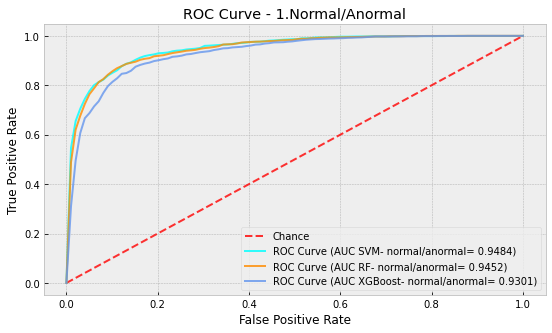

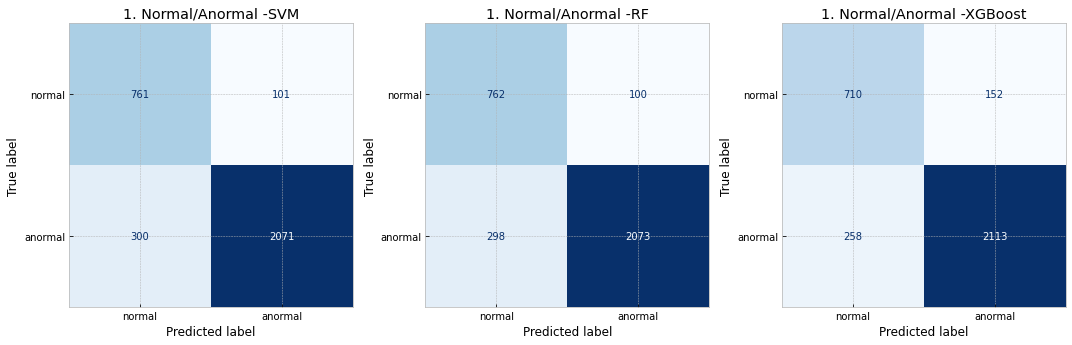

,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,1- Normal/Anormal,SVM,Selected features of cells nucleus,0.9117,0.9117,0.9117,0.0883,0.9117,0.9117
1,1- Normal/Anormal,RF,Selected features of cells nucleus,0.9124,0.9124,0.9124,0.0876,0.9124,0.9124
2,1- Normal/Anormal,XGBoost,Selected features of cells nucleus,0.9116,0.9116,0.9116,0.0884,0.9116,0.9116


In [390]:
# Exibe curvas roc, matrizes de confusão e métricas - Classificador binário:
plot_roc_curve_CV(roc_curve_list_bin, labels_list_bin, title = "ROC Curve - 1.Normal/Anormal")
plot_conf_matrix(preds_to_conf_matrix_bin, lbls=[0,1], disp_lbls=['normal', 'anormal'])
results_bin
    

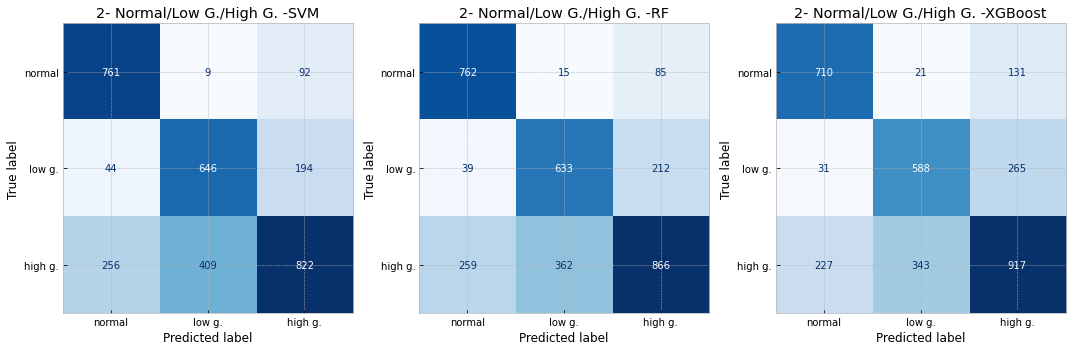

,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,2- Normal/Low G./High G.,SVM,Selected features of cells nucleus,0.6838,0.6838,0.6838,0.3162,0.6838,0.6838
1,2- Normal/Low G./High G.,RF,Selected features of cells nucleus,0.6948,0.6948,0.6948,0.3052,0.6948,0.6948
2,2- Normal/Low G./High G.,XGBoost,Selected features of cells nucleus,0.6833,0.6833,0.6833,0.3167,0.6833,0.6833


In [391]:
# Exibe matrizes de confusão e métricas - Classificador ternário:
plot_conf_matrix(preds_to_conf_matrix_ter, lbls=[0,1,2], disp_lbls=['normal','low g.', 'high g.'])
results_ter


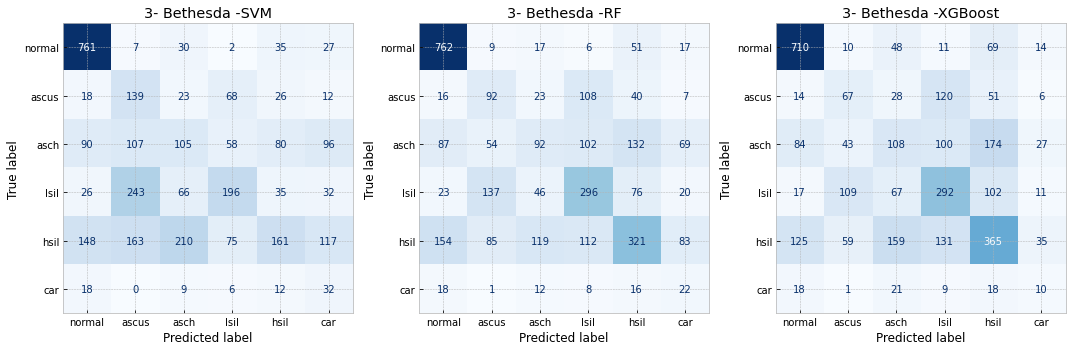

,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,3- Bethesda,SVM,Selected features of cells nucleus,0.4200,0.4200,0.4200,0.5800,0.4200,0.4200
1,3- Bethesda,RF,Selected features of cells nucleus,0.4795,0.4795,0.4795,0.5205,0.4795,0.4795
2,3- Bethesda,XGBoost,Selected features of cells nucleus,0.4722,0.4722,0.4722,0.5278,0.4722,0.4722


In [392]:
# Exibe matrizes de confusão e métricas - Classificador ternário:
plot_conf_matrix(preds_to_conf_matrix_bet, lbls=[0,1,2,3,4,5], disp_lbls=['normal','ascus', 'asch', 'lsil', 'hsil', 'car'])
results_bet